In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [3]:
import emblaze

from openai_embedding import *
from wandb_utils import *
from data import *

In [5]:
code_vecs_test, nl_vecs_test = load_embeddings(DATASET_TEST)

In [4]:
def score_vectors(code_vecs, nl_vecs):
    scores = np.matmul(nl_vecs, code_vecs.T)

    ranks = np.argsort(scores, axis=-1, kind="quicksort", order=None)[:, ::-1]

    return scores, ranks

def correct_rank(ranks):
    correct_rank = np.argwhere(ranks == np.arange(ranks.shape[0])[:, np.newaxis])[:, 1]

    return correct_rank

In [7]:
# Random baseline
rr_rand = 1 / (np.random.randint(0, 19210, 19210) + 1)
rr_rand.mean()

0.0004534565165913809

In [5]:
synthetic_dataset_vectors = {dataset.name:load_embeddings(dataset) for dataset in SYNTHETIC_DATASETS}

training_dataset_vectors = {"train":load_embeddings(DATASET_TRAIN)}
training_dataset_vectors.update(synthetic_dataset_vectors)

In [13]:
c, nl = load_embeddings(SYNTH_DATASET_D2C)
np.isnan(c).sum()/c.shape[1], np.isnan(nl).sum()/c.shape[1]

(0.0, 0.0)

In [6]:
def concatenate_vector_sets(vector_sets, max_size=None):
    vecs = np.concatenate([vs[: max_size] for vs in vector_sets], axis=0)
    # colors = np.concatenate((np.full(code_vecs.shape[0], 0), np.full(nl_vecs.shape[0], 1)), axis=0)
    if max_size is None:
        max_size = np.inf
    colors = np.concatenate(
        [np.full(min(vector_set.shape[0], max_size), i) for i, vector_set in enumerate(vector_sets)],
        axis=0,
    )

    return vecs, colors

In [72]:
# code_emb = emblaze.Embedding({emblaze.Field.POSITION: code_vecs_test[:500], emblaze.Field.COLOR: np.ones(code_vecs_test[:500].shape[0])}, metric='cosine')
# nl_emb = emblaze.Embedding({emblaze.Field.POSITION: nl_vecs_test[:500], emblaze.Field.COLOR: np.zeros(nl_vecs_test[:500].shape[0])}, metric='cosine')


# colors = np.concatenate((np.arange(500), np.arange(500)), axis=0)
vecs, colors = concatenate_vector_sets(
    [
        vs[:1000]
        for vs in (
            *training_dataset_vectors["train"],
            # training_dataset_vectors["d2c_semisynthetic"][0],
            # training_dataset_vectors["c2d_semisynthetic"][1],
        )
    ]
)
emb = emblaze.Embedding(
    {emblaze.Field.POSITION: vecs, emblaze.Field.COLOR: colors}, metric="cosine"
)

emb.compute_neighbors()

In [36]:
vecs, colors = concatenate_vector_sets(
    [
        vs[:1000]
        for vs in (
            *training_dataset_vectors["c2d_semisynthetic"],
        )
    ]
)
emb2 = emblaze.Embedding(
    {emblaze.Field.POSITION: vecs, emblaze.Field.COLOR: colors}, metric="cosine"
)

emb2.compute_neighbors()

In [ ]:
# umap_variants = emblaze.EmbeddingSet([code_emb.project(method=emblaze.ProjectionTechnique.PCA, n_components=2), nl_emb.project(method=emblaze.ProjectionTechnique.PCA, n_components=2)])
# umap_variants.compute_neighbors()
def project_embedding(emb):
    projections = (
        dict(method=emblaze.ProjectionTechnique.PCA, n_components=2),
        # dict(method=emblaze.ProjectionTechnique.UMAP),
        # dict(method=emblaze.ProjectionTechnique.TSNE),
    )
    return [emb.project(**projection) for projection in projections]

variants = emblaze.EmbeddingSet(project_embedding(emb) + project_embedding(emb2))

emblaze.Viewer(embeddings=variants)

In [63]:
# run_data = RunData("s6az2igf")

# code_vecs = run_data.code_vecs
# nl_vecs = run_data.nl_vecs

def calc_mrr(code_vecs, nl_vecs, trunc_ranks = True):
    scores, ranks = score_vectors(code_vecs, nl_vecs)

    r = correct_rank(ranks)

    rr = 1 / (r.copy() + 1)
    if trunc_ranks:
        rr[r >= 100] = 0

    return rr.mean()

print("test code to test nl", calc_mrr(code_vecs_test, nl_vecs_test))
print("train code to train nl", calc_mrr(*training_dataset_vectors["train"]))
print("c2d code to c2d nl", calc_mrr(*training_dataset_vectors["c2d_semisynthetic"]))
print("train code to c2d nl", calc_mrr(training_dataset_vectors["train"][0], training_dataset_vectors["c2d_semisynthetic"][1]))
print("c2d code to train nl", calc_mrr(training_dataset_vectors["d2c_semisynthetic"][0], training_dataset_vectors["train"][1]))

test code to test nl 0.4453751641350289
train code to train nl 0.7437443724709246
c2d code to c2d nl 0.9712700428911412
train code to c2d nl 0.9712279280284538
c2d code to train nl 0.8661646629026262


In [ ]:
data = WandBData()
df = data.df
df[df["run_id"] == "s6az2igf"]["test_mrr"]

0    0.307549
Name: test_mrr, dtype: float64

In [112]:
def fit_gaussian(vecs):
    mean = np.mean(vecs, axis=0)
    cov = np.cov(vecs, rowvar=False)
    return mean, cov

dataset_gaussians = {name: (fit_gaussian(code_vecs), fit_gaussian(nl_vecs)) for name, (code_vecs, nl_vecs) in training_dataset_vectors.items()}


for name, ((mean_code, cov_code), (mean_nl, cov_nl)) in dataset_gaussians.items():
    print(name)
    print(mean_code.mean(), mean_code.std(), np.linalg.slogdet(cov_code))
    print(mean_nl.mean(), mean_nl.std(), np.linalg.slogdet(cov_nl))


train
-0.0006473069938076154 0.020866533389732513 (1.0, -15226.324084846268)
-0.0007353518831490392 0.02097595087280287 (1.0, -15320.237911226272)
c2d_semisynthetic
-0.0006473141671182259 0.020866553689032685 (1.0, -15226.325344463554)
-0.0007033085422597738 0.020544815586717405 (1.0, -15320.405495163279)
d2c_semisynthetic
-0.0006457661560699938 0.02122733930286403 (1.0, -15519.918163947343)
-0.0007234086794552183 0.020412244579451535 (1.0, -15156.693799316194)
hardnegative_semisynthetic
-0.0006435828395363754 0.02083880863264175 (1.0, -15225.41278659864)
-0.0007212271353804573 0.020423873729285374 (1.0, -15205.421086725863)
hardpositive_semisynthetic
-0.0006430273879836196 0.02083134566313531 (1.0, -15276.870067088883)
-0.000720514776127109 0.020489033751946044 (1.0, -15301.212714362244)
subconcepts_8_synthetic
-0.000631979427860169 0.02105196979098824 (1.0, -15981.754574962026)
-0.0007166599085087908 0.02111690420582017 (1.0, -16187.374579156547)


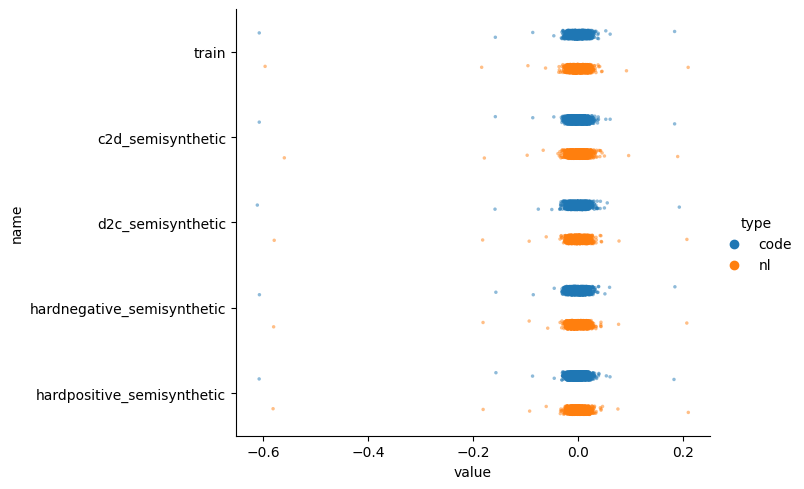

In [62]:
rows = []
for name, ((mean_code, cov_code), (mean_nl, cov_nl)) in dataset_gaussians.items():
    for m in mean_code:
        rows.append((name, "code", m))
    for m in mean_nl:
        rows.append((name, "nl", m))

df = pd.DataFrame(rows, columns=("name", "type", "value"))

sns.catplot(data=df, kind="strip", height=5, aspect=1.5, y="name", x="value", hue="type", dodge=True, alpha=0.5, marker=".")


In [10]:
# Perform PCA on the embedding matrix and plot the results
from sklearn.decomposition import PCA

pca_train = PCA(n_components=2)
pca_train.fit(concatenate_vector_sets(training_dataset_vectors["train"])[0])

pca_train_code = PCA(n_components=2)
pca_train_code.fit(training_dataset_vectors["train"][0])

pca_train_nl = PCA(n_components=2)
pca_train_nl.fit(training_dataset_vectors["train"][1])

PCA(n_components=2)

In [23]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

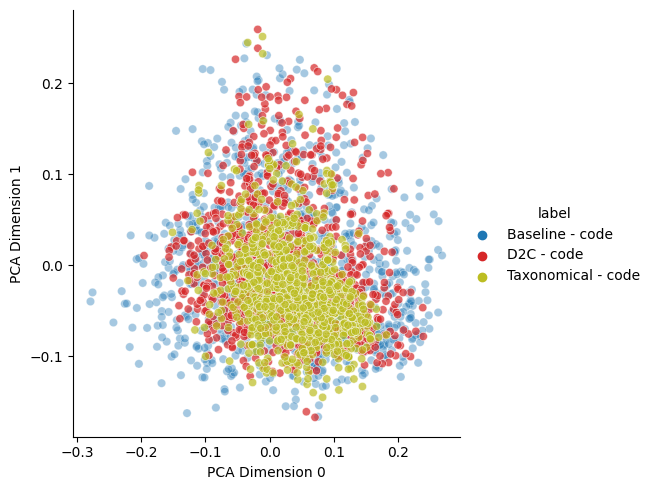

In [37]:
# sns.set_theme(style="white", palette=None)
label_palette = {
    "Baseline - code": "tab:blue",
    "Baseline - docstring": "tab:cyan",
    "C2D - docstring": "tab:orange",
    "D2C - code": "tab:red",
    "H+ - docstring": "tab:brown",
    "H+ - code": "tab:gray",
    "H- - docstring": "tab:purple",
    "H- - code": "tab:pink",
    "Taxonomical - docstring": "tab:green",
    "Taxonomical - code": "tab:olive",
}
def plot_pca(embeddings, labels, pca=pca_train):
    pca_embeddings = pca.transform(embeddings)

    pca_labels = ("PCA Dimension 0", "PCA Dimension 1")

    df = pd.DataFrame(pca_embeddings, columns=pca_labels)
    df["label"] = labels
    df["alpha"] = df["label"].apply(lambda x: 0.4 if "Baseline" in x else 0.7)

    g = sns.relplot(
        data=df,
        kind="scatter",
        x=pca_labels[0],
        y=pca_labels[1],
        hue="label",
        alpha=df["alpha"],
        marker="o",
        palette=label_palette,
    )
    return g


vector_sets = {
    "Baseline - code": training_dataset_vectors["train"][0],
    # "Baseline - docstring": training_dataset_vectors["train"][1],
    # "C2D - docstring": training_dataset_vectors["c2d_semisynthetic"][1],
    "D2C - code": training_dataset_vectors["d2c_semisynthetic"][0],
    # "H+ - docstring": training_dataset_vectors["hardpositive_semisynthetic"][1],
    # "H+ - code": training_dataset_vectors["hardpositive_semisynthetic"][0],
    # "H- - docstring": training_dataset_vectors["hardnegative_semisynthetic"][1],
    # "H- - code": training_dataset_vectors["hardnegative_semisynthetic"][0],
    # "Taxonomical - docstring": training_dataset_vectors["subconcepts_8_synthetic"][1],
    "Taxonomical - code": training_dataset_vectors["subconcepts_8_synthetic"][0],
}

vecs, colors = concatenate_vector_sets(vector_sets.values(), max_size=1000)

color_to_label = np.array(list(vector_sets.keys()))
dataset_labels = color_to_label[colors]

# plot_pca(*concatenate_vector_sets(training_dataset_vectors["train"], max_size=1000))
# plot_pca(training_dataset_vectors["c2d_semisynthetic"][1][:1000], np.full(1000, 2))
# g = plot_pca(vecs, dataset_labels, pca=pca_train)
g = plot_pca(vecs, dataset_labels, pca=pca_train_code)
# g = plot_pca(vecs, dataset_labels, pca=pca_train_nl)
# g.set(title="Synthetic training dataset embeddings in PCA space of real training dataset")

In [124]:
from sklearn.metrics.pairwise import paired_distances

# dataset_gaussians = {name: (fit_gaussian(code_vecs), fit_gaussian(nl_vecs)) for name, (code_vecs, nl_vecs) in training_dataset_vectors.items()}

code_nl_distances = {name: paired_distances(code_vecs, nl_vecs, metric="cosine") for name, (code_vecs, nl_vecs) in training_dataset_vectors.items()}

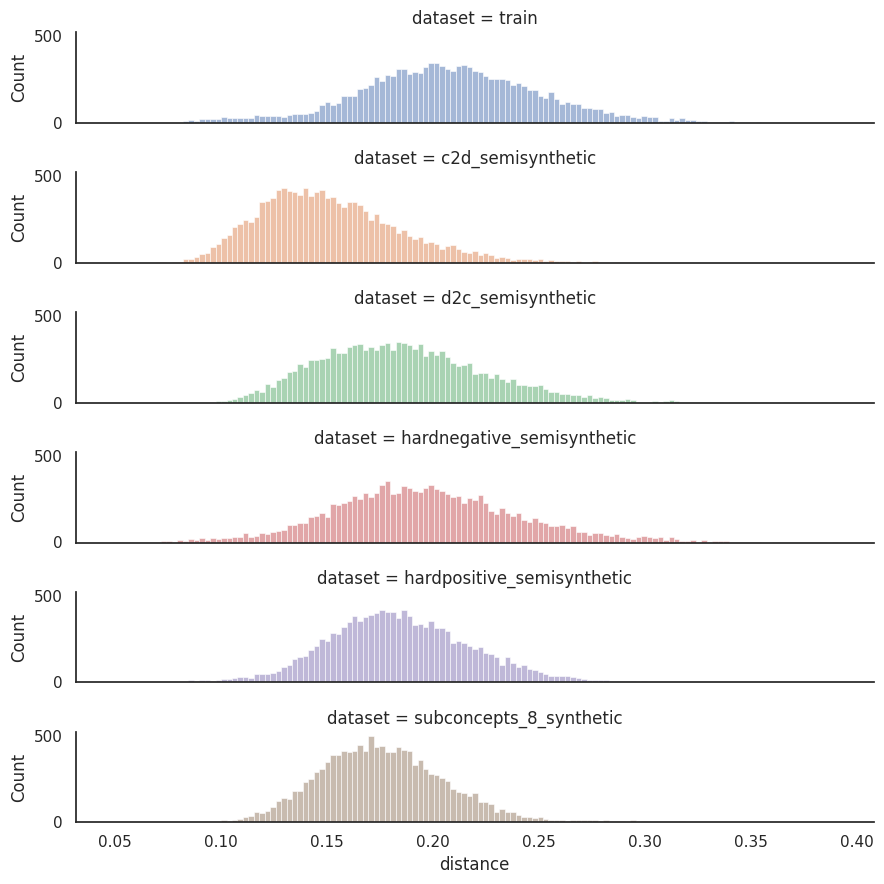

In [149]:
# Plot histogram of distances
distances = np.concatenate([ds for ds in code_nl_distances.values()])
dataset_labels = np.concatenate([[label] * ds.shape[0] for label, ds in code_nl_distances.items()])
example_ids = np.concatenate([np.arange(ds.shape[0]) for ds in code_nl_distances.values()])

df = pd.DataFrame({"distance": distances, "dataset": dataset_labels, "example_id": example_ids})

sns.displot(df, x="distance", row="dataset", hue="dataset", kind="hist", fill=True, aspect=6, height=1.5, legend=False)
# sns.catplot(df, x="distance", y="dataset", kind="violin", aspect=2, height=6)

In [8]:
import compcor.corpus_metrics as cm
from prdc import compute_prdc
from functools import lru_cache

corpus_hashes = {}
for name, (code, nl) in training_dataset_vectors.items():
    corpus_hashes[code.sum()] = (name, 0)
    corpus_hashes[nl.sum()] = (name, 1)
    corpus_hashes[np.concatenate((code, nl), axis=0).sum()] = (name, None)


@lru_cache(maxsize=None)
def prdc_metrics(corpus1_hash, corpus2_hash, k=5):
    key1, i1 = corpus_hashes[corpus1_hash]
    key2, i2 = corpus_hashes[corpus2_hash]

    corpus1 = (
        np.concatenate(training_dataset_vectors[key1], axis=0)
        if i1 is None
        else training_dataset_vectors[key1][i1]
    )
    corpus2 = (
        np.concatenate(training_dataset_vectors[key2], axis=0)
        if i2 is None
        else training_dataset_vectors[key2][i2]
    )

    return compute_prdc(corpus1, corpus2, k)


NEAREST_K = 5


def corpus_precision(corpus1, corpus2):
    return prdc_metrics(corpus1.sum(), corpus2.sum(), k=NEAREST_K)["precision"]


def corpus_recall(corpus1, corpus2):
    return prdc_metrics(corpus1.sum(), corpus2.sum(), k=NEAREST_K)["recall"]


def corpus_density(corpus1, corpus2):
    return prdc_metrics(corpus1.sum(), corpus2.sum(), k=NEAREST_K)["density"]


def corpus_coverage(corpus1, corpus2):
    return prdc_metrics(corpus1.sum(), corpus2.sum(), k=NEAREST_K)["coverage"]


def f1(p, r):
    p = np.clip(p, 0, 1)
    r = np.clip(r + 1e-6, 0, 1)

    return 2 * (p * r) / (p + r)


def pr_f1_distance(corpus1, corpus2, k=5):
    return 1 - f1(corpus_precision(corpus1, corpus2), corpus_recall(corpus1, corpus2))


def dc_f1_distance(corpus1, corpus2, k=5):
    return 1 - f1(corpus_density(corpus1, corpus2), corpus_coverage(corpus1, corpus2))


# corpus_precision(
#     training_dataset_vectors["train"][0], training_dataset_vectors["train"][1]
# )

In [9]:
corpus_metrics = [
    cm.fid_distance,
    cm.classifier_distance,
    # cm.mauve_distance,
    cm.medoid_distance,
    cm.IRPR_distance,
    cm.ttest_distance,
    pr_f1_distance,
    dc_f1_distance,
    corpus_precision,
    corpus_recall,
    corpus_density,
    corpus_coverage,
]


def compute_corpus_metrics(corpus1, corpus2):
    return {metric.__name__: metric(corpus1, corpus2) for metric in corpus_metrics}


compute_corpus_metrics(training_dataset_vectors["train"][0], training_dataset_vectors["train"][1])

Num real: 12800 Num fake: 12800


{'fid_distance': 0.1348365999210674,
 'classifier_distance': 1.0,
 'medoid_distance': 0.06062025598606324,
 'IRPR_distance': 0.2025060123947127,
 'ttest_distance': 0.981736763872718,
 'pr_f1_distance': 0.6185734885461085,
 'dc_f1_distance': 0.8245893124628132,
 'corpus_precision': 0.418828125,
 'corpus_recall': 0.35015625,
 'corpus_density': 0.11498437500000001,
 'corpus_coverage': 0.3696875}

In [10]:
train_synth_code_distances = {
    name: compute_corpus_metrics(training_dataset_vectors["train"][0], code_vecs)
    for name, (code_vecs, _nl_vecs) in synthetic_dataset_vectors.items()
}

train_synth_nl_distances = {
    name: compute_corpus_metrics(training_dataset_vectors["train"][1], nl_vecs)
    for name, (_code_vecs, nl_vecs) in synthetic_dataset_vectors.items()
}

Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800


In [11]:
synth_train_code_distances = {
    name: compute_corpus_metrics(code_vecs, training_dataset_vectors["train"][0])
    for name, (code_vecs, _nl_vecs) in synthetic_dataset_vectors.items()
}

synth_train_nl_distances = {
    name: compute_corpus_metrics(nl_vecs, training_dataset_vectors["train"][1])
    for name, (_code_vecs, nl_vecs) in synthetic_dataset_vectors.items()
}

Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800


In [12]:
code_nl_distances = {
    name: compute_corpus_metrics(code_vecs, nl_vecs)
    for name, (code_vecs, nl_vecs) in training_dataset_vectors.items()
}

Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800


In [13]:
nl_code_distances = {
    name: compute_corpus_metrics(nl_vecs, code_vecs)
    for name, (code_vecs, nl_vecs) in training_dataset_vectors.items()
}

Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800


In [24]:
from collections import defaultdict

rows = defaultdict(list)
for name, metrics in train_synth_code_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["data_type"].append("code")
        rows["dataset_to"].append(name)
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

for name, metrics in train_synth_nl_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["data_type"].append("docstring")
        rows["dataset_to"].append(name)
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

train_synth_dist_df = pd.DataFrame(rows)


rows = defaultdict(list)
for name, metrics in synth_train_code_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["dataset_from"].append(name)
        rows["data_type"].append("code")
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

for name, metrics in synth_train_nl_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["dataset_from"].append(name)
        rows["data_type"].append("docstring")
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

synth_train_dist_df = pd.DataFrame(rows)


rows = defaultdict(list)
for name, metrics in code_nl_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["dataset_from"].append(name + "-code")
        rows["dataset_to"].append(name + "-nl")
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

for name, metrics in nl_code_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["dataset_from"].append(name + "-nl")
        rows["dataset_to"].append(name + "-code")
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

code_nl_dist_df = pd.DataFrame(rows)

<Axes: xlabel='metric', ylabel='dataset_to'>

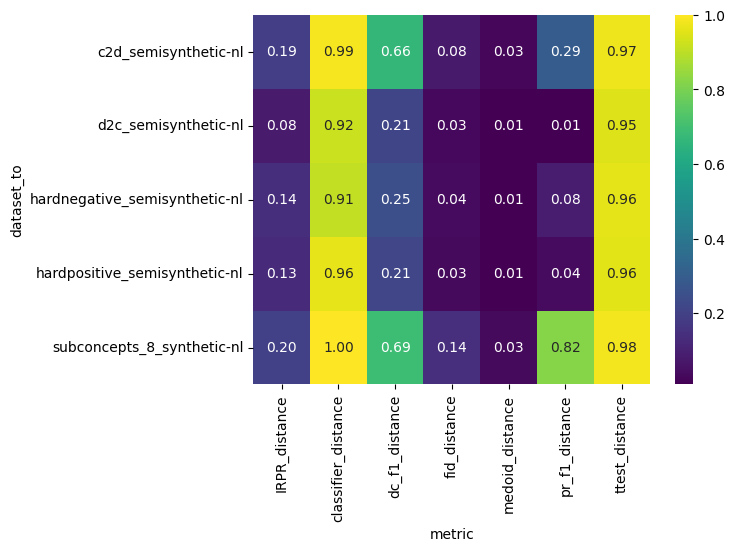

In [46]:
# metric = "pr_f1_distance"
df = dist_df[dist_df["dataset_from"] == "train-nl"]
df = df[df["metric"].str.contains("distance")]

df = df.pivot(index="dataset_to", columns="metric", values="value")

# sns.catplot(data=df, kind="bar", x="dataset_to", y="value", row="metric", aspect=2, height=6)
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")

In [46]:
train_train_code = compute_corpus_metrics(training_dataset_vectors["train"][0], training_dataset_vectors["train"][0])
train_train_nl = compute_corpus_metrics(training_dataset_vectors["train"][1], training_dataset_vectors["train"][1])

Num real: 12800 Num fake: 12800
Num real: 12800 Num fake: 12800


In [55]:
rows = defaultdict(list)

for name, metrics in train_train_code.items():
    rows["data_type"].append("code")
    rows["dataset_to"].append("train")
    rows["metric"].append(name)
    rows["value"].append(metrics)

for name, metrics in train_train_nl.items():
    rows["data_type"].append("docstring")
    rows["dataset_to"].append("train")
    rows["metric"].append(name)
    rows["value"].append(metrics)

train_train_dist_df = pd.DataFrame(rows)

['Taxonomical' 'C2D' 'H+' 'H-' 'D2C' 'Baseline']


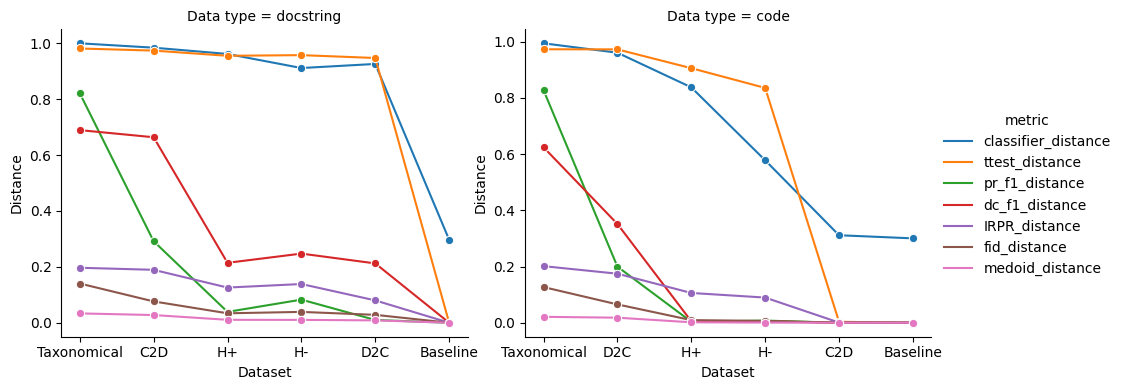

In [63]:
df = train_synth_dist_df
df = pd.concat([df, train_train_dist_df], axis=0)

df = df[df["metric"].str.contains("distance")]
df = df.sort_values(["data_type", "value"], ascending=False)
df = df.replace(
    {
        "dataset_to": {
            "c2d_semisynthetic": "C2D",
            "d2c_semisynthetic": "D2C",
            "subconcepts_8_synthetic": "Taxonomical",
            "hardpositive_semisynthetic": "H+",
            "hardnegative_semisynthetic": "H-",
            "train": "Baseline",
        },
    }
)
df["hue"] = df["data_type"] + " " + df["metric"]
df = df.rename(columns={"data_type": "Data type"})

print(df["dataset_to"].unique())

g = sns.relplot(
    df,
    kind="line",
    x="dataset_to",
    y="value",
    hue="metric",
    col="Data type",
    facet_kws=dict(sharey=False, sharex=False),
    aspect=1.2,
    height=4,
    marker="o",
)
# rotate x-axis labels
# g.set_xticklabels(rotation=90)
g.set(xlabel="Dataset", ylabel="Distance")

/home/james/.pyenv/versions/3.8.16/envs/ML3.8/lib/python3.8/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


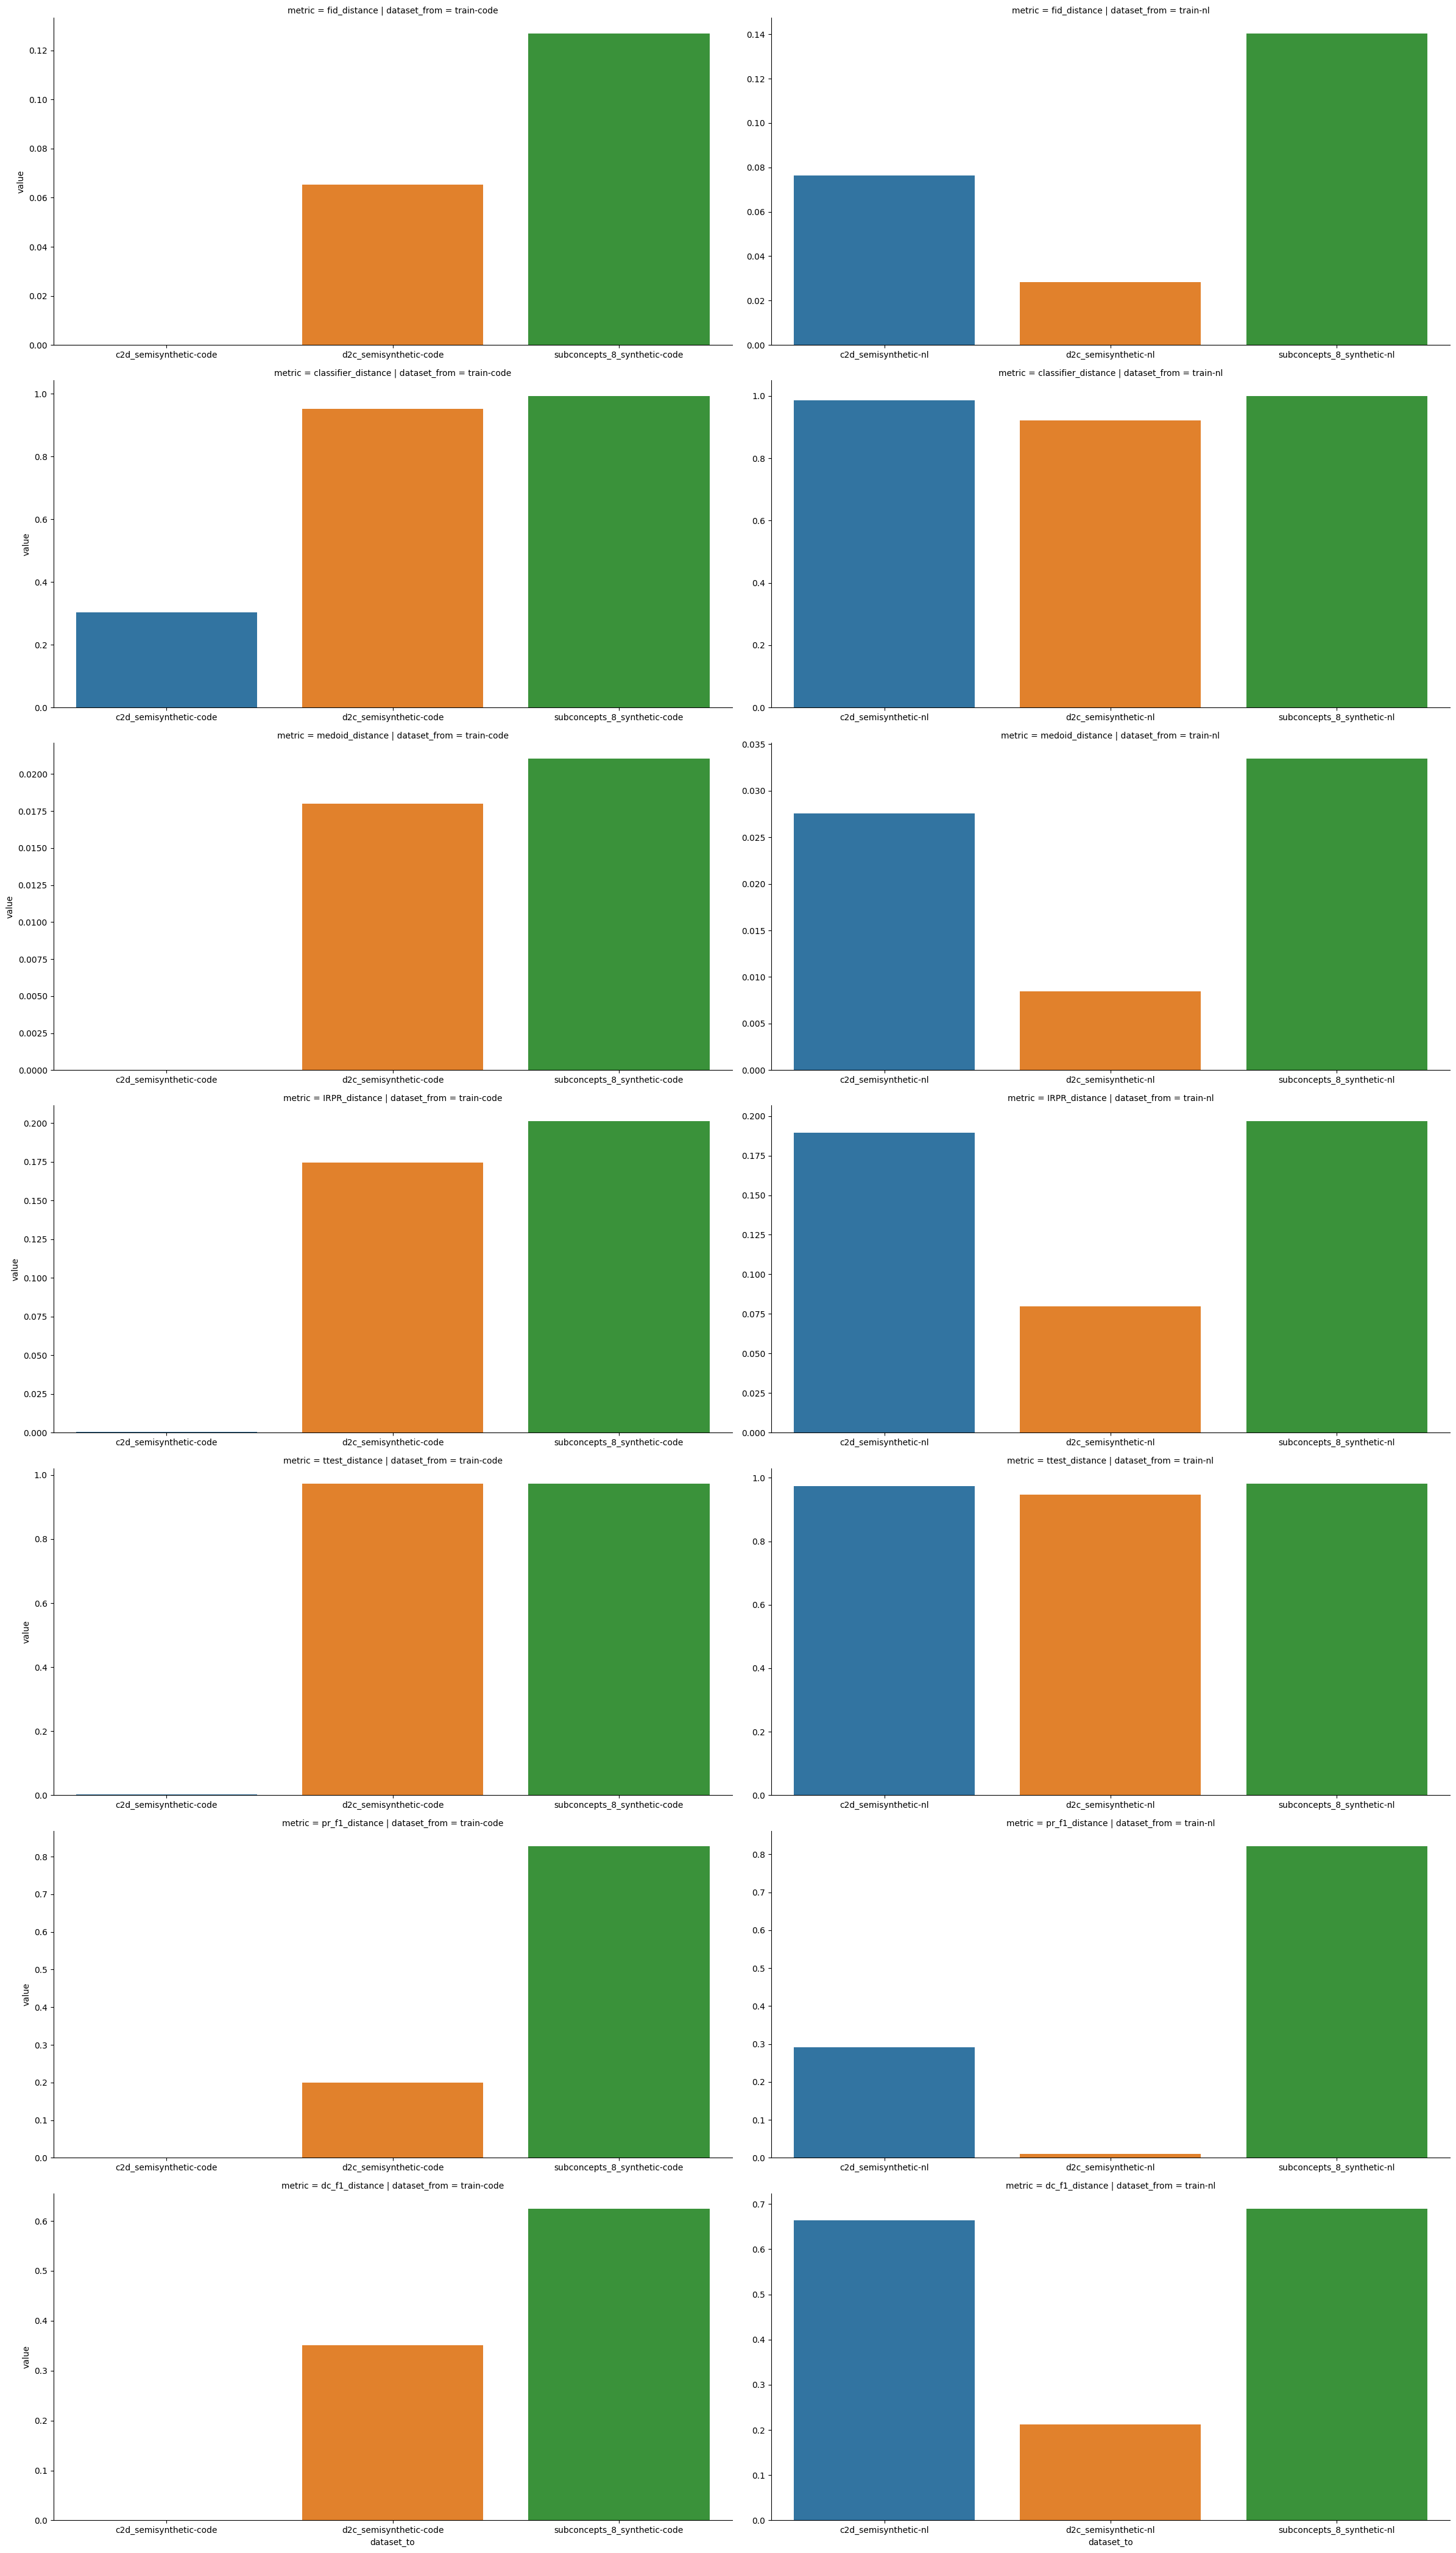

In [63]:
df = dist_df
df = df[df["metric"].str.contains("distance")]
df = df[~df["dataset_to"].str.contains("train")]
df = df[~df["dataset_to"].str.contains("hard")]

sns.catplot(data=df, kind="bar", row="metric", x="dataset_to", y="value", col="dataset_from", aspect=2, height=6, sharex=False, sharey=False)

In [66]:
# train_synth_distances = {
#     name: compute_corpus_metrics(
#         np.concatenate(training_dataset_vectors["train"], axis=0),
#         np.concatenate(vecs, axis=0),
#     )
#     for name, vecs in synthetic_dataset_vectors.items()
# }

Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600
Num real: 25600 Num fake: 25600


: 

In [ ]:
rows = defaultdict(list)

for name, metrics in train_synth_distances.items():
    for metric_name, metric_value in metrics.items():
        rows["dataset_from"].append("train")
        rows["dataset_to"].append(name)
        rows["metric"].append(metric_name)
        rows["value"].append(metric_value)

# for name, metrics in synth_train_distances.items():
#     for metric_name, metric_value in metrics.items():
#         rows["dataset_from"].append(name)
#         rows["dataset_to"].append("train")
#         rows["metric"].append(metric_name)
#         rows["value"].append(metric_value)

concat_dist_df = pd.DataFrame(rows)